# Lab 8: Neural networks

In this lab we will build dense neural networks on the MNIST dataset.



## Load the data and create train-test splits

In [16]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import tensorflow.keras as tf
import random

from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [17]:
# init tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.utils.set_random_seed(
    seed
)

C:\Users\duamelo\AppData\Local\Temp\ipykernel_6308\3841004139.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  mnist = oml.datasets.get_dataset(554)
C:\Users\duamelo\AppData\Local\Temp\ipykernel_6308\3841004139.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');


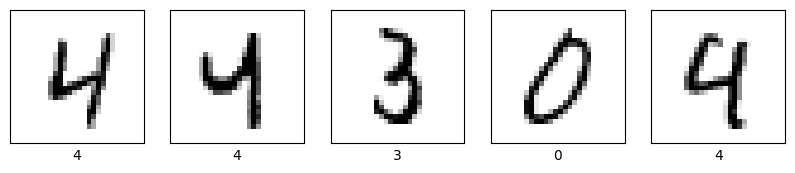

In [19]:
# Download MNIST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(554)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(y[n]))
plt.show();

In [20]:
y

array([5, 0, 4, ..., 4, 5, 6])

In [21]:
# For MNIST, there exists a predefined stratified train-test split of 60000-10000. We therefore don't shuffle or stratify here.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, random_state=0, stratify=y)

In [22]:
X_valid, X_dev, y_valid, y_dev = train_test_split(X_train, y_train, train_size=48000, random_state=0, stratify=y_train)

## Exercise 1: Preprocessing
* Normalize the data: map each feature value from its current representation (an integer between 0 and 255) to a floating-point value between 0 and 1.0.
* Store the floating-point values in `x_train_normalized` and `x_test_normalized`.
* Map the class label to a on-hot-encoded value. Store in `y_train_encoded` and `y_test_encoded`.

In [23]:
x_train_normalized = X_train.astype('float32') / 255
x_valid_normalized = X_valid.astype('float32') / 255
x_dev_normalized = X_dev.astype('float32') / 255

y_train_encoded = tf.utils.to_categorical(y_train, 10)
y_valid_encoded = tf.utils.to_categorical(y_valid, 10)
y_dev_encoded = tf.utils.to_categorical(y_dev, 10)

## Exercise 2: Create a deep neural net model

Implement a `create_model` function which defines the topography of the deep neural net, specifying the following:

* The number of layers in the deep neural net: Use 2 dense layers for now.
* The number of nodes in each layer: these are parameters of your function.
* Any regularization layers. Add at least one dropout layer.
* The optimizer and learning rate. Make the learning rate a parameter of your function as well.

Consider:
* What should be the shape of the input layer?
* Which activation function you will need for the last layer, since this is a 10-class classification problem?

In [24]:
### Create and compile a 'deep' neural net
def create_model(layer_1_units=32, layer_2_units=10, learning_rate=0.003, dropout_rate=0.3):
    model = tf.models.Sequential()
    model.add(tf.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.layers.Dense(layer_1_units, activation='relu'))
    model.add(tf.layers.Dropout(dropout_rate))
    model.add(tf.layers.Dense(layer_2_units, activation='softmax'))
    
    
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [25]:
model1 = create_model()
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 25450 (99.41 KB)
Trainable params: 25450 (99.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Exercise 3: Create a training function
Implement a `train_model` function which trains and evaluates a given model.
It should do a train-validation split and report the train and validation loss and accuracy, and return the training history.

In [26]:
def train_model(model, X, y, validation_split=0.2, epochs=10, batch_size=None, eval_set=None, verbose=True):
    """
    model: the model to train
    X, y: the training data and labels
    validation_split: the percentage of data set aside for the validation set
    epochs: the number of epochs to train for
    batch_size: the batch size for minibatch SGD
    eval_set: if not None, a tuple (X_val, y_val) with a validation set to evaluate the model on
    """
    
    if eval_set is None:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=0, stratify=y)
    else:
        X_train, y_train = X, y
        X_val, y_val = eval_set
    
    early_stopping = tf.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,
                        verbose=verbose, callbacks=[early_stopping])
    
    
    return history

## Exercise 4: Evaluate the model

Train the model with a learning rate of 0.003, 50 epochs, batch size 4000, and a validation set that is 20% of the total training data.
Use default settings otherwise. Plot the learning curve of the loss, validation loss, accuracy, and validation accuracy. Finally, report the performance on the test set.

Feel free to use the plotting function below, or implement the callback from the tutorial to see results in real time.

In [27]:
# Helper plotting function
#
# history: the history object returned by the fit function
history = train_model(model1, x_train_normalized, y_train_encoded, epochs=50, batch_size=4000, eval_set=(x_dev_normalized, y_dev_encoded))

# list_of_metrics: the metrics to plot
list_of_metrics = ['accuracy', 'loss']

def plot_curve(history, list_of_metrics):

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m, lw=2)

    plt.legend()

Epoch 1/50
15/15 [==============================] - 1s 24ms/step - loss: 1.6474 - accuracy: 0.4550 - val_loss: 0.9120 - val_accuracy: 0.7808
Epoch 2/50
15/15 [==============================] - 0s 13ms/step - loss: 0.8804 - accuracy: 0.7326 - val_loss: 0.5375 - val_accuracy: 0.8647
Epoch 3/50
15/15 [==============================] - 0s 13ms/step - loss: 0.6465 - accuracy: 0.8040 - val_loss: 0.4203 - val_accuracy: 0.8874
Epoch 4/50
15/15 [==============================] - 0s 12ms/step - loss: 0.5501 - accuracy: 0.8346 - val_loss: 0.3649 - val_accuracy: 0.8994
Epoch 5/50
15/15 [==============================] - 0s 17ms/step - loss: 0.4963 - accuracy: 0.8507 - val_loss: 0.3321 - val_accuracy: 0.9093
Epoch 6/50
15/15 [==============================] - 0s 13ms/step - loss: 0.4619 - accuracy: 0.8617 - val_loss: 0.3112 - val_accuracy: 0.9147
Epoch 7/50
15/15 [==============================] - 0s 13ms/step - loss: 0.4384 - accuracy: 0.8683 - val_loss: 0.2924 - val_accuracy: 0.9173
Epoch 8/50
15

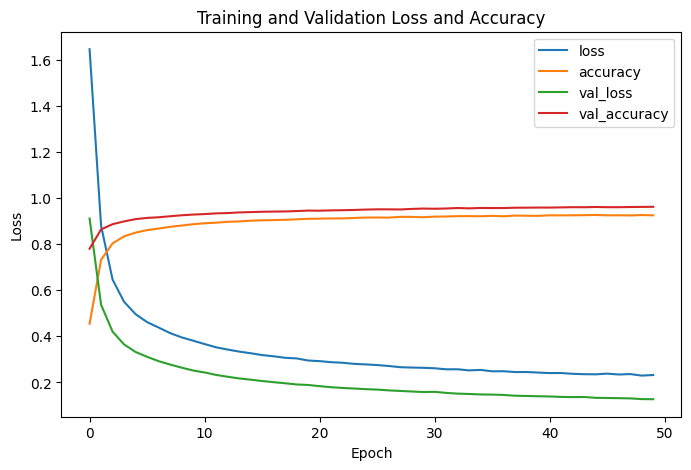

In [28]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training and Validation Loss and Accuracy")
plt.show()

In [29]:
y_pred = model1.predict(x_valid_normalized)
y_pred = np.argmax(y_pred, axis=1)
accuracy = np.mean(y_pred == y_valid)
print(f"Accuracy: {accuracy}")

1500/1500 [==============================] - 2s 2ms/step
Accuracy: 0.9655625


## Exercise 5: Optimize the model

Try to optimize the model, either manually or with a tuning method. At least optimize the following:
* the number of hidden layers
* the number of nodes in each layer
* the amount of dropout layers and the dropout rate

Try to reach at least 96% accuracy against the test set.

In [30]:
grid_search = {
    'layer_1_units': [32, 64],
    'layer_2_units': [10],
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.5],
    'batch_size': [32, 64, 2000, 4000],
    'epochs': [50, 100, 200]
    
}

# manual hyperparameter tuning
results = pd.DataFrame(columns=['layer_1_units', 'layer_2_units', 'learning_rate', 'dropout_rate', 'train_accuracy',
                                'validation_accuracy', 'test_accuracy'])
for layer_1_units in grid_search['layer_1_units']:
    for layer_2_units in grid_search['layer_2_units']:
        for learning_rate in grid_search['learning_rate']:
            for dropout_rate in grid_search['dropout_rate']:
                for batch_size in grid_search['batch_size']:
                    for epochs in grid_search['epochs']:
                        model = create_model(layer_1_units, layer_2_units, learning_rate, dropout_rate)
                        history = train_model(model, x_train_normalized, y_train_encoded, epochs=epochs, batch_size=batch_size, eval_set=(x_dev_normalized, y_dev_encoded), verbose=False)
                        train_accuracy = history.history['accuracy'][-1]
                        validation_accuracy = history.history['val_accuracy'][-1]
                        y_pred = model.predict(x_valid_normalized)
                        y_pred = np.argmax(y_pred, axis=1)
                        test_accuracy = np.mean(y_pred == y_valid)
                        # print accuracies and hyperparameters
                        print(f"{layer_1_units}, {layer_2_units}, {learning_rate}, {dropout_rate}, {batch_size}, {epochs}, {train_accuracy}, {validation_accuracy}, {test_accuracy}")
                        results = pd.concat([results, pd.DataFrame({'layer_1_units': [layer_1_units],
                                                                    'layer_2_units': [layer_2_units],
                                                                    'learning_rate': [learning_rate],
                                                                    'dropout_rate': [dropout_rate],
                                                                    'train_accuracy': [train_accuracy],
                                                                    'validation_accuracy': [validation_accuracy],
                                                                    'test_accuracy': [test_accuracy]}, index=[f"{layer_1_units}_{layer_2_units}_{learning_rate}_{dropout_rate}_{batch_size}_{epochs}"])])


Restoring model weights from the end of the best epoch: 43.
Epoch 48: early stopping
1500/1500 [==============================] - 3s 2ms/step
32, 10, 0.001, 0.2, 32, 50, 0.9604499936103821, 0.9838333129882812, 0.9861666666666666
Restoring model weights from the end of the best epoch: 67.
Epoch 72: early stopping
1500/1500 [==============================] - 3s 2ms/step
32, 10, 0.001, 0.2, 32, 100, 0.9673833250999451, 0.9890833497047424, 0.9902708333333333
